<summary>Table of Contents</summary>

- [1. Comparison of models](#1-comparison-of-models)
- [2. Sequence length](#2-sequence-length)
- [3. Self-supervised](#3-self-supervised)
- [4. Ablation study](#4-ablation-study)
- [5. TimeLLM](#5-timellm)
- [6. Decomposition](#6-decomposition)

This script summarizes results from all experiments and represents them in plots. On the plots is UK, but in tables is GB. GB here is United Kingdom.

In [1]:
import pandas as pd
import os
from utils.helper import style_dataframe, \
                         map_country_name, \
                         read_results_csv, \
                         group_and_reindex_df, \
                         choose_best_model, \
                         calculate_improvement
                         
from utils.plot_final_results import plot_results_models_multiple_countries, \
                                      plot_comparison_for_metrics, \
                                      plot_barplots


# 1. Input length

In [2]:
patchtst_df = read_results_csv('patchtst/patchtst_128.csv',
                               columns_to_extract = ('PatchTST/42', ['RMSE', 'MAE'])
                               )
patchtst_21_df = read_results_csv('patchtst/patchtst_168_21_patch.csv',
                                   columns_to_extract = ('PatchTST/21', ['RMSE', 'MAE'])
                                   )
patchtst_64_df = read_results_csv('patchtst/patchtst_bs128_pl512.csv',
                                   columns_to_extract = ('PatchTST/64', ['RMSE', 'MAE'])
                                   )

all_df_store = pd.concat([patchtst_21_df, patchtst_df, patchtst_64_df], axis=1)

# Change country codes to country names
level_names = all_df_store.index.names
all_df_store.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df_store.index],
    names=level_names
)
# Scale
scale = 10**2
all_df_scale_store = all_df_store * scale

# With best PatchTST configurations
result_df_unscaled = choose_best_model(all_df_store,
                                       'PatchTST')
result_df = result_df_unscaled * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale_store, decimal_places=2)
styled_df


In [3]:
best_vs_base = pd.concat([result_df, all_df_scale_store.loc[:, all_df_store.columns.get_level_values('Model') == 'PatchTST/42']], axis=1)
best_vs_base = calculate_improvement(best_vs_base, 
                                      base_mae_model='PatchTST', 
                                      model_to_compare_mae='PatchTST/42',
                                      grouped_by_models=False)
print(f"Average improvement of MAE: {(best_vs_base.loc[best_vs_base['mae_improvement']!=0]['mae_improvement'].mean()).round(2)} %.")
print(f"Average improvement of RMSE: {(best_vs_base.loc[best_vs_base['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)} %.")

Average improvement of MAE: 1.71 %.
Average improvement of RMSE: 1.42 %.


In [4]:
best_vs_base['mae_improvement'] = best_vs_base['mae_improvement'].apply(lambda x: str(x) + '%' if x != 0 else '--')
best_vs_base['rmse_improvement'] = best_vs_base['rmse_improvement'].apply(lambda x: str(x) + '%' if x != 0 else '--')
best_vs_base.round(2)

Model                   PatchTST        PatchTST/42        rmse_improvement  \
Metrics                     RMSE    MAE        RMSE    MAE                    
Country        Pred_len                                                       
Germany        24          14.43   9.11       14.43   9.11               --   
               96          18.61  12.82       18.89  12.91            1.48%   
               168         19.27  13.54       19.58  13.66            1.56%   
United Kingdom 24          15.65  10.27       15.84  10.36            1.18%   
               96          20.02  14.09       20.57  14.37            2.69%   
               168         20.62  14.66       21.32  15.11            3.27%   
Spain          24           9.87   6.07        9.87   6.07               --   
               96          13.49   8.79       13.49   8.79               --   
               168         14.21   9.48       14.21   9.48               --   
France         24           9.97   5.66       10.02   5.81            0.52%   
               96          13.63   8.20       13.66   8.42            0.22%   
               168         14.26   8.86       14.34   9.05            0.59%   
Italy          24           9.95   5.82        9.98   5.81            0.36%   
               96          13.15   7.98       13.36   8.16            1.56%   
               168         13.75   8.58       14.06   8.75            2.18%   

Model                   mae_improvement  
Metrics                                  
Country        Pred_len                  
Germany        24                    --  
               96                 0.71%  
               168                0.86%  
United Kingdom 24                 0.92%  
               96                  1.9%  
               168                3.02%  
Spain          24                    --  
               96                    --  
               168                   --  
France         24                 2.55%  
               96                 2.59%  
               168                2.11%  
Italy          24                 -0.1%  
               96                 2.29%  
               168                1.93%

In [5]:
print(best_vs_base[['mae_improvement', 'rmse_improvement']].reset_index(drop=True))

Model   mae_improvement rmse_improvement
Metrics                                 
0                    --               --
1                 0.71%            1.48%
2                 0.86%            1.56%
3                 0.92%            1.18%
4                  1.9%            2.69%
5                 3.02%            3.27%
6                    --               --
7                    --               --
8                    --               --
9                 2.55%            0.52%
10                2.59%            0.22%
11                2.11%            0.59%
12                -0.1%            0.36%
13                2.29%            1.56%
14                1.93%            2.18%


In [6]:
# Save styled dataframe to HTML
path = './stored_elements/tables'

if not os.path.exists(path):
    os.makedirs(path)
styled_df.to_html(os.path.join(path, 'patchtst_input_length_10_power_2.html'), index=True)

# 2. Comparison of models

In [7]:
# Read data
naive_df = read_results_csv('naive/metrics_persistence_countries_minmax.csv',
                            columns_to_extract = ('Persistence', ['RMSE', 'MAE'])
                            )
arima_df = read_results_csv('arima/metrics_arima_countries_minmax.csv',
                             columns_to_extract = ('(S)ARIMA', ['RMSE', 'MAE'])
                             )
informer_df = read_results_csv('informer/informer.csv',
                               columns_to_extract = ('Informer', ['RMSE', 'MAE'])
                               )

# Concat all dfs with default PatchTST
all_df = pd.concat([patchtst_df, informer_df, arima_df, naive_df], axis=1)

# Scale
scale = 10**2

# Change country codes to country names
level_names = all_df.index.names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index], 
    names=level_names
)
all_df_scale = all_df * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [8]:
# Concat all dfs with best PatchTST - FINAL TABLE
all_df_with_result = pd.concat(
    [result_df, all_df_scale.loc[:, all_df_scale.columns.get_level_values('Model') != 'PatchTST/42']],
    axis=1
)

unscaled_for_plots = all_df_with_result / scale

all_df_with_result.columns.names = ['Model', 'Metrics']

# Highlight the minimum values in bold.
styled_df = style_dataframe(all_df_with_result, decimal_places=2)
styled_df

In [9]:
informer_improvement = all_df_with_result.copy()
informer_improvement = calculate_improvement(informer_improvement, 
                      base_mae_model='PatchTST', 
                      model_to_compare_mae='Informer',
                      grouped_by_models=False).round(2)
informer_improvement

Model                   PatchTST        Informer        (S)ARIMA         \
Metrics                     RMSE    MAE     RMSE    MAE     RMSE    MAE   
Country        Pred_len                                                   
Germany        24          14.43   9.11    15.97  10.63    11.15   9.32   
               96          18.61  12.82    20.39  14.68    20.28  16.49   
               168         19.27  13.54    21.42  15.39    22.79  18.51   
United Kingdom 24          15.65  10.27    17.64  12.03    14.41  12.01   
               96          20.02  14.09    22.50  16.01    21.53  17.69   
               168         20.62  14.66    25.91  18.29    22.67  18.28   
Spain          24           9.87   6.07    17.42  10.45     9.68   7.89   
               96          13.49   8.79    21.24  13.74    14.17  11.22   
               168         14.21   9.48    21.38  14.08    17.61  13.59   
France         24           9.97   5.66    11.71   7.17     7.60   6.06   
               96          13.63   8.20    14.80   9.20    12.54   9.81   
               168         14.26   8.86    15.14   9.53    14.89  11.50   
Italy          24           9.95   5.82    10.67   6.60     8.64   6.98   
               96          13.15   7.98    13.70   9.16    13.12  10.33   
               168         13.75   8.58    14.53   9.75    16.57  12.76   

Model                   Persistence        rmse_improvement mae_improvement  
Metrics                        RMSE    MAE                                   
Country        Pred_len                                                      
Germany        24             19.61  13.87             9.64           14.32  
               96             26.14  19.69             8.74           12.67  
               168            23.39  17.01            10.06           12.03  
United Kingdom 24             19.89  14.45            11.31           14.64  
               96             25.54  19.42            11.02           11.95  
               168            24.69  18.56            20.43           19.88  
Spain          24             14.06   9.43            43.38           41.88  
               96             19.67  13.92            36.49           35.98  
               168            17.74  12.38            33.52           32.68  
France         24             12.24   8.00            14.86           21.00  
               96             17.82  12.50             7.94           10.86  
               168            16.29  10.81             5.82            7.06  
Italy          24             14.40   9.66             6.77           11.81  
               96             19.71  14.10             3.98           12.98  
               168            15.69  10.92             5.34           11.98

In [10]:
informer_improvement['mae_improvement'].groupby('Country').mean()

Country
France            12.973333
Germany           13.006667
Italy             12.256667
Spain             36.846667
United Kingdom    15.490000
Name: mae_improvement, dtype: float64

In [11]:
informer_improvement['rmse_improvement'].groupby('Country').mean()

Country
France             9.540000
Germany            9.480000
Italy              5.363333
Spain             37.796667
United Kingdom    14.253333
Name: rmse_improvement, dtype: float64

In [12]:
print(f"Average improvement of MAE: {(informer_improvement.loc[informer_improvement['mae_improvement']!=0]['mae_improvement'].mean()).round(2)} %.")
print(f"Average improvement of RMSE: {(informer_improvement.loc[informer_improvement['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)} %.")

Average improvement of MAE: 18.11 %.
Average improvement of RMSE: 15.29 %.


In [13]:
second_best_improvement = all_df_with_result.copy()
second_best_improvement = calculate_improvement(second_best_improvement, 
                      base_mae_model='PatchTST', 
                      grouped_by_models=False).round(2)
second_best_improvement
                                                    

Model                   PatchTST        Informer        (S)ARIMA         \
Metrics                     RMSE    MAE     RMSE    MAE     RMSE    MAE   
Country        Pred_len                                                   
Germany        24          14.43   9.11    15.97  10.63    11.15   9.32   
               96          18.61  12.82    20.39  14.68    20.28  16.49   
               168         19.27  13.54    21.42  15.39    22.79  18.51   
United Kingdom 24          15.65  10.27    17.64  12.03    14.41  12.01   
               96          20.02  14.09    22.50  16.01    21.53  17.69   
               168         20.62  14.66    25.91  18.29    22.67  18.28   
Spain          24           9.87   6.07    17.42  10.45     9.68   7.89   
               96          13.49   8.79    21.24  13.74    14.17  11.22   
               168         14.21   9.48    21.38  14.08    17.61  13.59   
France         24           9.97   5.66    11.71   7.17     7.60   6.06   
               96          13.63   8.20    14.80   9.20    12.54   9.81   
               168         14.26   8.86    15.14   9.53    14.89  11.50   
Italy          24           9.95   5.82    10.67   6.60     8.64   6.98   
               96          13.15   7.98    13.70   9.16    13.12  10.33   
               168         13.75   8.58    14.53   9.75    16.57  12.76   

Model                   Persistence        improvement_rmse improvement_mae  
Metrics                        RMSE    MAE                                   
Country        Pred_len                                                      
Germany        24             19.61  13.87             0.00            2.26  
               96             26.14  19.69             8.26           12.67  
               168            23.39  17.01            10.06           12.03  
United Kingdom 24             19.89  14.45             0.00           14.53  
               96             25.54  19.42             7.00           11.95  
               168            24.69  18.56             9.04           19.83  
Spain          24             14.06   9.43             0.00           23.02  
               96             19.67  13.92             4.82           21.61  
               168            17.74  12.38            19.31           23.45  
France         24             12.24   8.00             0.00            6.48  
               96             17.82  12.50             0.00           10.86  
               168            16.29  10.81             4.26            7.06  
Italy          24             14.40   9.66             0.00           11.81  
               96             19.71  14.10             0.00           12.98  
               168            15.69  10.92             5.34           11.98

In [14]:
print(f"Average improvement of MAE: {(second_best_improvement.loc[second_best_improvement['improvement_mae']!=0]['improvement_mae'].mean()).round(2)} %.")
print(f"Average improvement of RMSE: {(second_best_improvement.loc[second_best_improvement['improvement_rmse']!=0]['improvement_rmse'].mean()).round(2)} %.")

Average improvement of MAE: 13.5 %.
Average improvement of RMSE: 8.51 %.


In [15]:
second_best_improvement['improvement_mae'].groupby('Country').mean()

Country
France             8.133333
Germany            8.986667
Italy             12.256667
Spain             22.693333
United Kingdom    15.436667
Name: improvement_mae, dtype: float64

In [16]:
second_best_improvement['improvement_rmse'].groupby('Country').mean()

Country
France            1.420000
Germany           6.106667
Italy             1.780000
Spain             8.043333
United Kingdom    5.346667
Name: improvement_rmse, dtype: float64

In [17]:
second_best_improvement['improvement_mae'].groupby('Pred_len').mean()

Pred_len
24     11.620
96     14.014
168    14.870
Name: improvement_mae, dtype: float64

In [18]:
# Save styled dataframe to HTML
path = './stored_elements/tables'

if not os.path.exists(path):
    os.makedirs(path)
styled_df.to_html(os.path.join(path, 'model_comparison_10_power_2.html'), index=True)

Create plots.

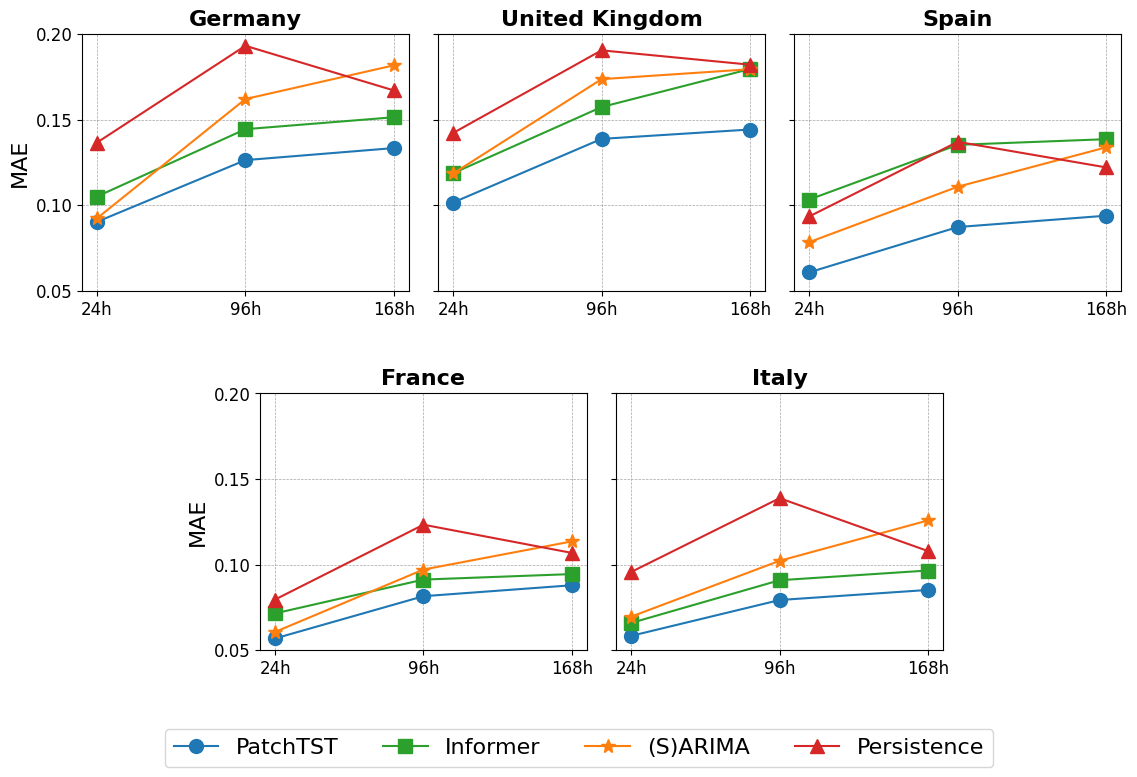

In [19]:
plot_results_models_multiple_countries(unscaled_for_plots, 
                                       function="lines", 
                                       eval_metric='MAE',
                                       decimal_places=2
                                       )

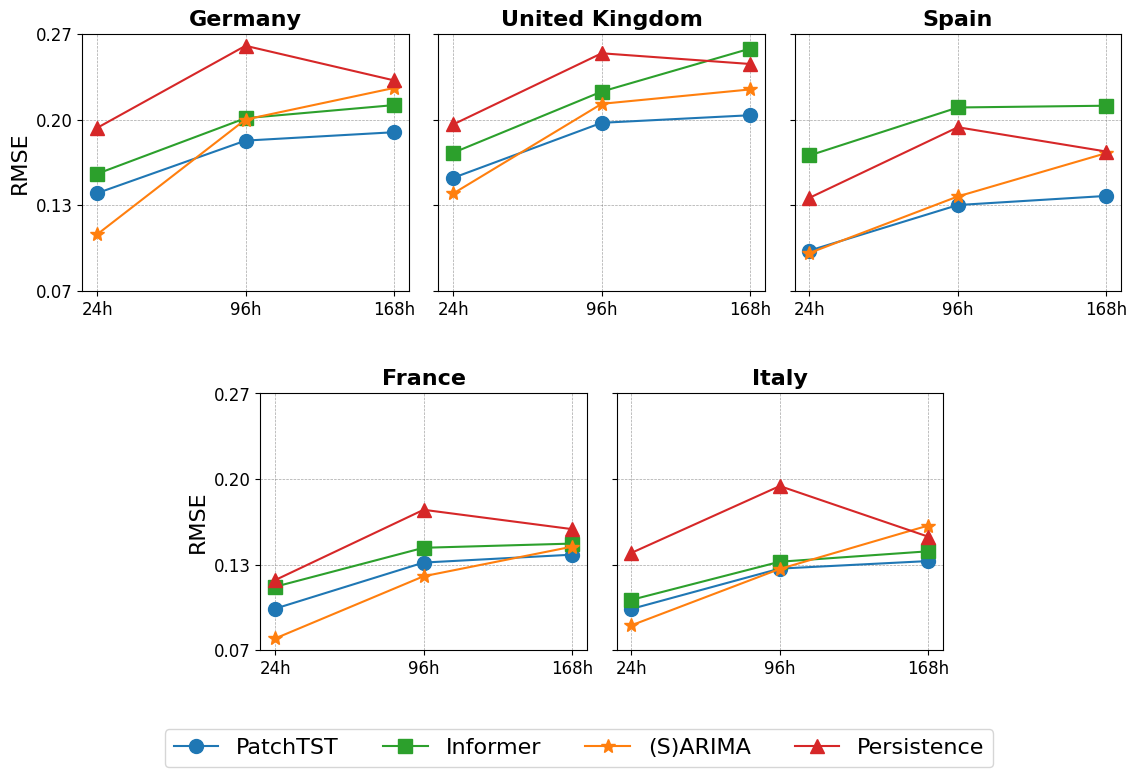

In [20]:
plot_results_models_multiple_countries(unscaled_for_plots, 
                                       function="lines", 
                                       eval_metric='RMSE',
                                       decimal_places=2)

# 3. Self-supervised

In [21]:
# Read data
self_sup = read_results_csv('patchtst/finetune_results.csv',
                                    columns_to_extract = ('Self-supervised', ['RMSE', 'MAE'])
                                    ).sort_index(ascending=True)
self_supervised = self_sup.copy()
# Change country codes to country names
self_supervised.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in self_supervised.index],
    names=level_names
)

all_df = pd.concat([self_supervised, result_df_unscaled], axis=1)

# Scale
all_df_scale = all_df * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [22]:
styled_df.to_html(os.path.join(path, 'self_supervised_10_power_2.html'), index=True)

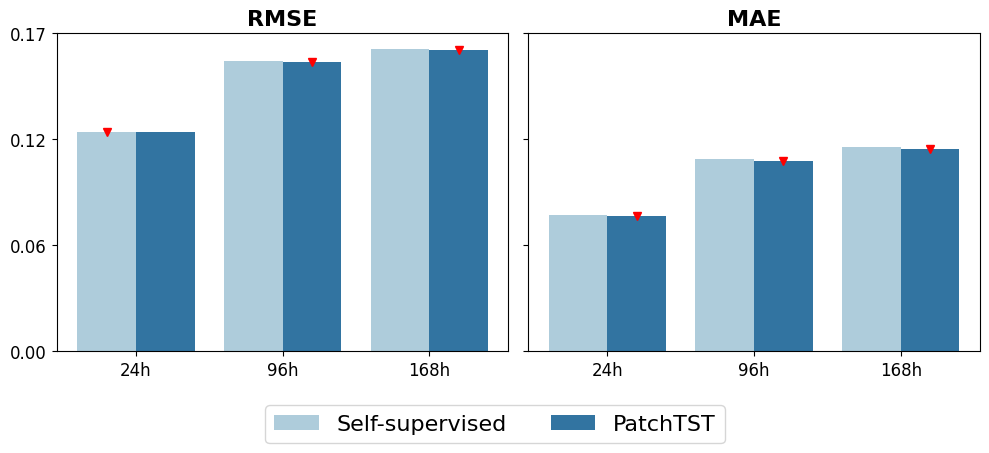

In [23]:
# all together
# Not visible
# Averaged by country
to_group = 'Pred_len'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, plot_max_markers=False, palette="Paired")

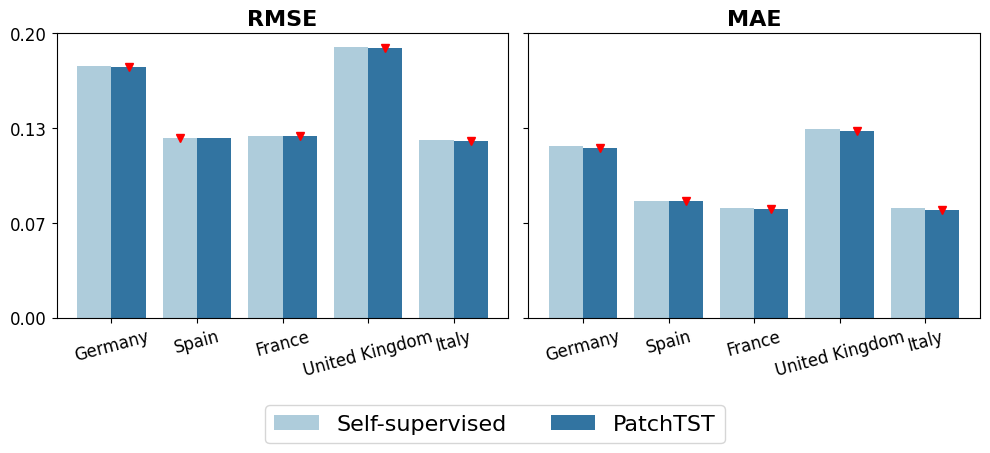

In [24]:
# Averaged by country
to_group = 'Country'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, plot_max_markers=False, palette="Paired")

# 4. Ablation study

In [25]:
# Read data
no_revin = read_results_csv('patchtst/patchtst_no_revin.csv', 
                           columns_to_extract = ('-RevIN', ['RMSE', 'MAE'])
                           )
patchtst_mix_features = read_results_csv('patchtst/patchtst_channel_mixing_MIX_FEATURES.csv',
                                        columns_to_extract = ('CM', ['RMSE', 'MAE'])
                                        )

patchtst_mix_corr = read_results_csv('patchtst/channel_mixing_new.csv',
                                        columns_to_extract = ('CM', ['RMSE', 'MAE'])
                                        )
no_patch = read_results_csv('patchtst/patchtst_no_patching.csv', 
                           columns_to_extract = ('- P', ['RMSE', 'MAE'])
                           )

all_df = pd.concat([no_revin, patchtst_mix_features, no_patch], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

all_df = pd.concat([result_df_unscaled, all_df], axis=1)

# Scale
all_df_scale = all_df * scale

# Highlight maximum values in bold
styled_df = style_dataframe(all_df_scale, 'max', decimal_places=2)
styled_df

In [26]:
revin = all_df_scale.copy()
revin = calculate_improvement(revin, 
                      base_mae_model='-RevIN', 
                      model_to_compare_mae='PatchTST',
                      grouped_by_models=False).round(2)
revin

Model                   PatchTST        -RevIN            CM           - P  \
Metrics                     RMSE    MAE   RMSE    MAE   RMSE    MAE   RMSE   
Country        Pred_len                                                      
Germany        24          14.43   9.11  14.77   9.52  15.96  10.60  14.80   
               96          18.61  12.82  19.06  13.06  19.53  13.84  18.82   
               168         19.27  13.54  19.75  13.73  20.01  14.28  19.39   
United Kingdom 24          15.65  10.27  16.31  10.95  16.91  11.75  16.04   
               96          20.02  14.09  20.14  14.31  20.69  14.71  20.07   
               168         20.62  14.66  21.95  15.56  21.21  15.20  20.75   
Spain          24           9.87   6.07  13.55   8.41  10.68   6.92  10.27   
               96          13.49   8.79  17.61  11.43  14.37   9.65  13.88   
               168         14.21   9.48  18.14  12.12  15.14  10.32  14.63   
France         24           9.97   5.66  10.48   6.40  10.49   6.11  10.42   
               96          13.63   8.20  13.92   8.73  13.83   8.49  14.15   
               168         14.26   8.86  14.65   9.29  14.13   8.89  14.83   
Italy          24           9.95   5.82  10.42   6.58  10.33   6.20  10.12   
               96          13.15   7.98  13.37   8.60  13.72   8.60  13.53   
               168         13.75   8.58  13.75   8.97  14.08   9.02  13.94   

Model                          rmse_improvement mae_improvement  
Metrics                    MAE                                   
Country        Pred_len                                          
Germany        24         9.50            -2.33           -4.53  
               96        13.17            -2.43           -1.85  
               168       13.65            -2.47           -1.37  
United Kingdom 24        10.57            -4.25           -6.68  
               96        14.15            -0.60           -1.51  
               168       14.70            -6.47           -6.19  
Spain          24         6.48           -37.32          -38.52  
               96         9.23           -30.58          -29.95  
               168        9.81           -27.68          -27.90  
France         24         5.99            -5.08          -13.07  
               96         8.58            -2.14           -6.43  
               168        9.11            -2.73           -4.85  
Italy          24         6.07            -4.79          -13.03  
               96         8.31            -1.66           -7.80  
               168        8.77            -0.03           -4.52

In [27]:
revin['mae_improvement'].groupby('Country').mean()

Country
France            -8.116667
Germany           -2.583333
Italy             -8.450000
Spain            -32.123333
United Kingdom    -4.793333
Name: mae_improvement, dtype: float64

In [28]:
revin['rmse_improvement'].groupby('Country').mean()

Country
France            -3.316667
Germany           -2.410000
Italy             -2.160000
Spain            -31.860000
United Kingdom    -3.773333
Name: rmse_improvement, dtype: float64

In [29]:
revin['mae_improvement'].groupby('Pred_len').mean()

Pred_len
24    -15.166
96     -9.508
168    -8.966
Name: mae_improvement, dtype: float64

In [30]:
print(f"Average reduction of MAE: {(revin.loc[revin['mae_improvement']!=0]['mae_improvement'].mean()).round(2)} %.")
print(f"Average reduction of RMSE: {(revin.loc[revin['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)} %.")

Average reduction of MAE: -11.21 %.
Average reduction of RMSE: -8.7 %.


In [31]:
channel_mixing = all_df_scale.copy()
channel_mixing = calculate_improvement(channel_mixing, 
                      base_mae_model='CM', 
                      model_to_compare_mae='PatchTST',
                      grouped_by_models=False).round(2)
channel_mixing

Model                   PatchTST        -RevIN            CM           - P  \
Metrics                     RMSE    MAE   RMSE    MAE   RMSE    MAE   RMSE   
Country        Pred_len                                                      
Germany        24          14.43   9.11  14.77   9.52  15.96  10.60  14.80   
               96          18.61  12.82  19.06  13.06  19.53  13.84  18.82   
               168         19.27  13.54  19.75  13.73  20.01  14.28  19.39   
United Kingdom 24          15.65  10.27  16.31  10.95  16.91  11.75  16.04   
               96          20.02  14.09  20.14  14.31  20.69  14.71  20.07   
               168         20.62  14.66  21.95  15.56  21.21  15.20  20.75   
Spain          24           9.87   6.07  13.55   8.41  10.68   6.92  10.27   
               96          13.49   8.79  17.61  11.43  14.37   9.65  13.88   
               168         14.21   9.48  18.14  12.12  15.14  10.32  14.63   
France         24           9.97   5.66  10.48   6.40  10.49   6.11  10.42   
               96          13.63   8.20  13.92   8.73  13.83   8.49  14.15   
               168         14.26   8.86  14.65   9.29  14.13   8.89  14.83   
Italy          24           9.95   5.82  10.42   6.58  10.33   6.20  10.12   
               96          13.15   7.98  13.37   8.60  13.72   8.60  13.53   
               168         13.75   8.58  13.75   8.97  14.08   9.02  13.94   

Model                          rmse_improvement mae_improvement  
Metrics                    MAE                                   
Country        Pred_len                                          
Germany        24         9.50           -10.60          -16.43  
               96        13.17            -4.97           -8.00  
               168       13.65            -3.82           -5.45  
United Kingdom 24        10.57            -8.03          -14.37  
               96        14.15            -3.33           -4.39  
               168       14.70            -2.88           -3.73  
Spain          24         6.48            -8.26          -13.94  
               96         9.23            -6.56           -9.76  
               168        9.81            -6.51           -8.96  
France         24         5.99            -5.21           -7.78  
               96         8.58            -1.45           -3.52  
               168        9.11             0.91           -0.36  
Italy          24         6.07            -3.85           -6.53  
               96         8.31            -4.31           -7.82  
               168        8.77            -2.42           -5.08

In [32]:
channel_mixing['mae_improvement'].groupby('Country').mean()

Country
France            -3.886667
Germany           -9.960000
Italy             -6.476667
Spain            -10.886667
United Kingdom    -7.496667
Name: mae_improvement, dtype: float64

In [33]:
channel_mixing['rmse_improvement'].groupby('Country').mean()

Country
France           -1.916667
Germany          -6.463333
Italy            -3.526667
Spain            -7.110000
United Kingdom   -4.746667
Name: rmse_improvement, dtype: float64

In [34]:
channel_mixing['mae_improvement'].groupby('Pred_len').mean()

Pred_len
24    -11.810
96     -6.698
168    -4.716
Name: mae_improvement, dtype: float64

In [35]:
channel_mixing['rmse_improvement'].groupby('Pred_len').mean()

Pred_len
24    -7.190
96    -4.124
168   -2.944
Name: rmse_improvement, dtype: float64

In [36]:
print(f"Average reduction of MAE: {(channel_mixing.loc[channel_mixing['mae_improvement']!=0]['mae_improvement'].mean()).round(2)} %.")
print(f"Average reduction of RMSE: {(channel_mixing.loc[channel_mixing['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)} %.")

Average reduction of MAE: -7.74 %.
Average reduction of RMSE: -4.75 %.


In [37]:
# Change country codes to country names
patchtst_mix_corr.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in patchtst_mix_corr.index],
    names=level_names
)

patchtst_mix_corr = pd.concat([result_df_unscaled, patchtst_mix_corr], axis=1)

# Scale
patchtst_mix_corr_scale = patchtst_mix_corr * scale

# Highlight maximum values in bold
styled_df = style_dataframe(patchtst_mix_corr_scale, 'max', decimal_places=2)
styled_df

In [38]:
channel_mixing = patchtst_mix_corr_scale.copy()
channel_mixing = calculate_improvement(patchtst_mix_corr_scale, 
                      base_mae_model='CM', 
                      model_to_compare_mae='PatchTST',
                      grouped_by_models=False).round(2)
channel_mixing

Model                   PatchTST            CM        rmse_improvement  \
Metrics                     RMSE    MAE   RMSE    MAE                    
Country        Pred_len                                                  
Germany        24          14.43   9.11  15.29  10.06            -5.94   
               96          18.61  12.82  19.53  13.84            -4.97   
               168         19.27  13.54  20.01  14.28            -3.82   
United Kingdom 24          15.65  10.27  16.30  10.94            -4.13   
               96          20.02  14.09  20.69  14.71            -3.33   
               168         20.62  14.66  21.21  15.20            -2.88   
Spain          24           9.87   6.07  10.68   6.92            -8.26   
               96          13.49   8.79  14.37   9.65            -6.56   
               168         14.21   9.48  15.14  10.32            -6.51   
France         24           9.97   5.66  10.49   6.11            -5.21   
               96          13.63   8.20  13.83   8.49            -1.45   
               168         14.26   8.86  14.13   8.89             0.91   
Italy          24           9.95   5.82  10.33   6.20            -3.85   
               96          13.15   7.98  13.72   8.60            -4.31   
               168         13.75   8.58  14.08   9.02            -2.42   

Model                   mae_improvement  
Metrics                                  
Country        Pred_len                  
Germany        24                -10.43  
               96                 -8.00  
               168                -5.45  
United Kingdom 24                 -6.58  
               96                 -4.39  
               168                -3.73  
Spain          24                -13.94  
               96                 -9.76  
               168                -8.96  
France         24                 -7.78  
               96                 -3.52  
               168                -0.36  
Italy          24                 -6.53  
               96                 -7.82  
               168                -5.08

In [39]:
channel_mixing['mae_improvement'].groupby('Country').mean()

Country
France            -3.886667
Germany           -7.960000
Italy             -6.476667
Spain            -10.886667
United Kingdom    -4.900000
Name: mae_improvement, dtype: float64

In [40]:
channel_mixing['rmse_improvement'].groupby('Country').mean()

Country
France           -1.916667
Germany          -4.910000
Italy            -3.526667
Spain            -7.110000
United Kingdom   -3.446667
Name: rmse_improvement, dtype: float64

In [41]:
channel_mixing['mae_improvement'].groupby('Pred_len').mean()

Pred_len
24    -9.052
96    -6.698
168   -4.716
Name: mae_improvement, dtype: float64

In [42]:
channel_mixing['rmse_improvement'].groupby('Pred_len').mean()

Pred_len
24    -5.478
96    -4.124
168   -2.944
Name: rmse_improvement, dtype: float64

In [43]:
print(f"Average reduction of MAE: {(channel_mixing.loc[channel_mixing['mae_improvement']!=0]['mae_improvement'].mean()).round(2)} %.")
print(f"Average reduction of RMSE: {(channel_mixing.loc[channel_mixing['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)} %.")

Average reduction of MAE: -6.82 %.
Average reduction of RMSE: -4.18 %.


In [44]:
patching = all_df_scale.copy()
patching = calculate_improvement(patching, 
                      base_mae_model='- P', 
                      model_to_compare_mae='PatchTST',
                      grouped_by_models=False).round(2)
patching

Model                   PatchTST        -RevIN            CM           - P  \
Metrics                     RMSE    MAE   RMSE    MAE   RMSE    MAE   RMSE   
Country        Pred_len                                                      
Germany        24          14.43   9.11  14.77   9.52  15.96  10.60  14.80   
               96          18.61  12.82  19.06  13.06  19.53  13.84  18.82   
               168         19.27  13.54  19.75  13.73  20.01  14.28  19.39   
United Kingdom 24          15.65  10.27  16.31  10.95  16.91  11.75  16.04   
               96          20.02  14.09  20.14  14.31  20.69  14.71  20.07   
               168         20.62  14.66  21.95  15.56  21.21  15.20  20.75   
Spain          24           9.87   6.07  13.55   8.41  10.68   6.92  10.27   
               96          13.49   8.79  17.61  11.43  14.37   9.65  13.88   
               168         14.21   9.48  18.14  12.12  15.14  10.32  14.63   
France         24           9.97   5.66  10.48   6.40  10.49   6.11  10.42   
               96          13.63   8.20  13.92   8.73  13.83   8.49  14.15   
               168         14.26   8.86  14.65   9.29  14.13   8.89  14.83   
Italy          24           9.95   5.82  10.42   6.58  10.33   6.20  10.12   
               96          13.15   7.98  13.37   8.60  13.72   8.60  13.53   
               168         13.75   8.58  13.75   8.97  14.08   9.02  13.94   

Model                          rmse_improvement mae_improvement  
Metrics                    MAE                                   
Country        Pred_len                                          
Germany        24         9.50            -2.57           -4.30  
               96        13.17            -1.16           -2.76  
               168       13.65            -0.61           -0.79  
United Kingdom 24        10.57            -2.50           -2.94  
               96        14.15            -0.27           -0.40  
               168       14.70            -0.63           -0.31  
Spain          24         6.48            -4.13           -6.74  
               96         9.23            -2.88           -4.93  
               168        9.81            -2.93           -3.53  
France         24         5.99            -4.50           -5.81  
               96         8.58            -3.80           -4.53  
               168        9.11            -4.03           -2.85  
Italy          24         6.07            -1.79           -4.37  
               96         8.31            -2.87           -4.20  
               168        8.77            -1.40           -2.20

In [45]:
patching['mae_improvement'].groupby('Country').mean()

Country
France           -4.396667
Germany          -2.616667
Italy            -3.590000
Spain            -5.066667
United Kingdom   -1.216667
Name: mae_improvement, dtype: float64

In [46]:
patching['mae_improvement'].groupby('Pred_len').mean()

Pred_len
24    -4.832
96    -3.364
168   -1.936
Name: mae_improvement, dtype: float64

In [47]:
print(f"Average reduction of MAE: {(patching.loc[patching['mae_improvement']!=0]['mae_improvement'].mean()).round(2)} %.")
print(f"Average reduction of RMSE: {(patching.loc[patching['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)} %.")

Average reduction of MAE: -3.38 %.
Average reduction of RMSE: -2.4 %.


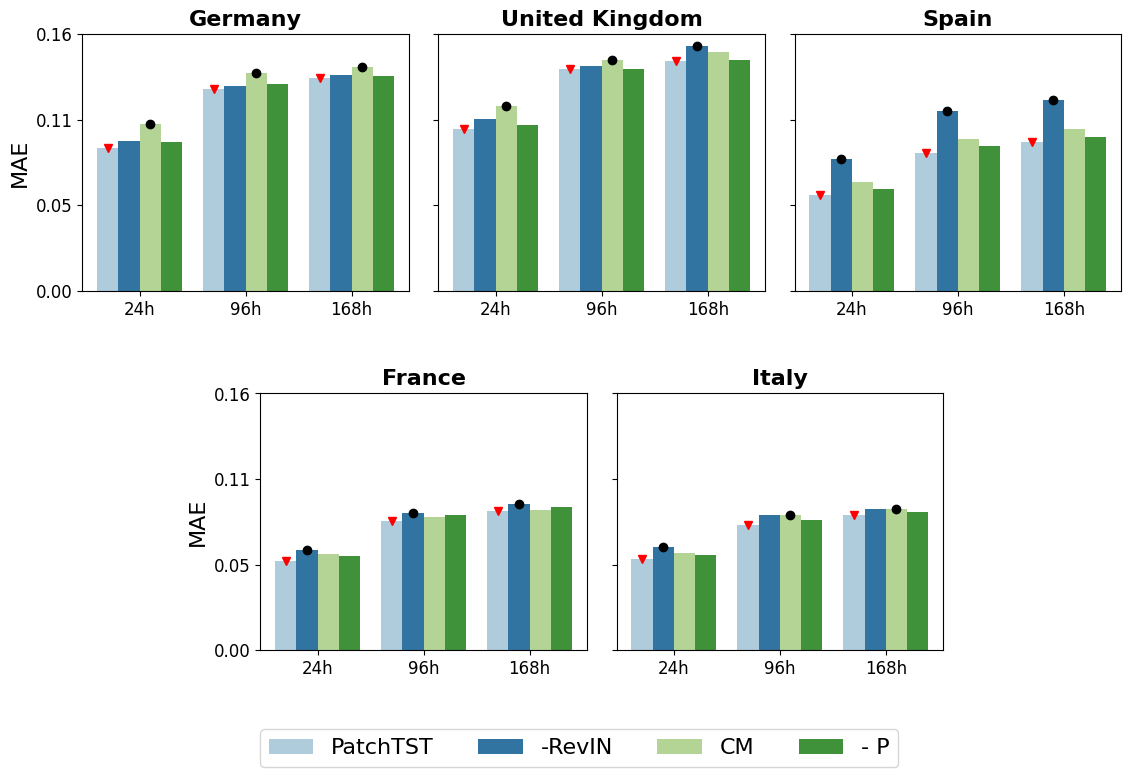

In [48]:
plot_results_models_multiple_countries(all_df, 
                                       function="bars", 
                                       eval_metric='MAE',
                                       palette="Paired",
                                       plot_max_markers=True,
                                       plot_min_markers=True,
                                       decimal_places=2)

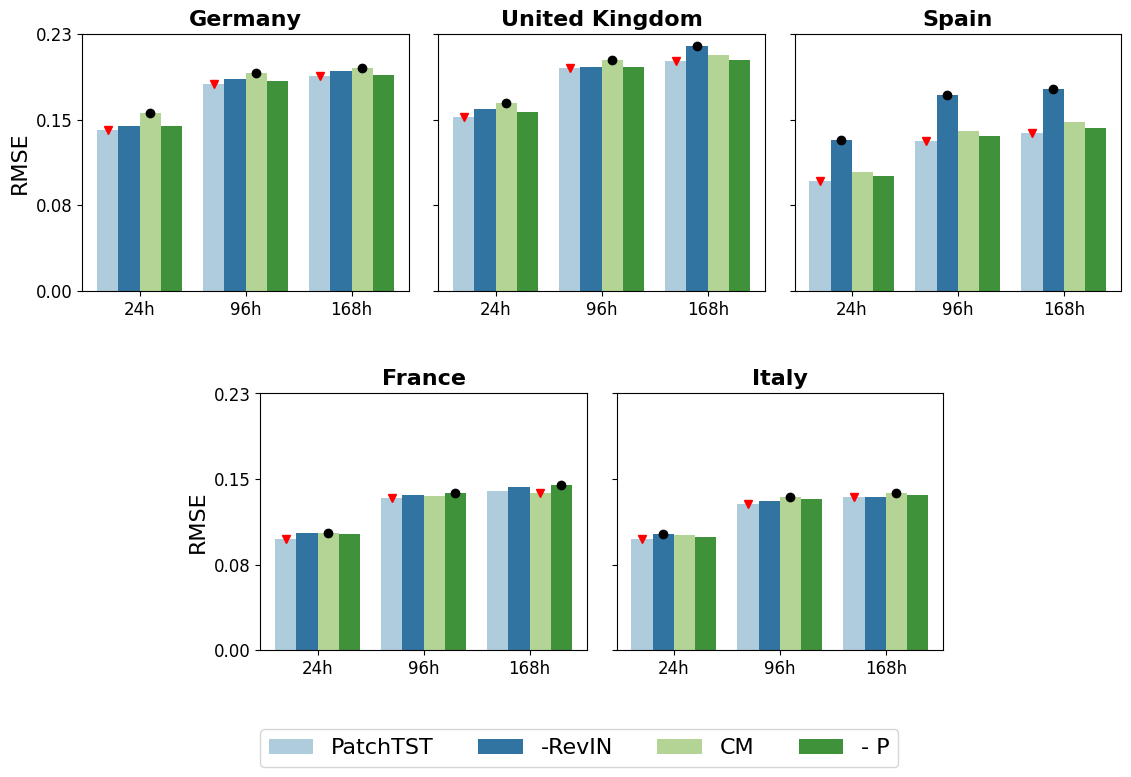

In [49]:
plot_results_models_multiple_countries(all_df, 
                                       function="bars", 
                                       eval_metric='RMSE',
                                       palette="Paired",
                                       plot_max_markers=True,
                                       plot_min_markers=True,
                                       decimal_places=2)

In [51]:
styled_df.to_html(os.path.join(path, 'ablation_10_power_2.html'), index=True)

# 5. TimeLLM

In [53]:
timellm_df = read_results_csv('timellm/timellm.csv', 
                              columns_to_extract = ('TimeLLM', ['RMSE', 'MAE'])
                              )

#all_df = pd.concat([timellm_df, timellm_df_336, patchtst_64_df, patchtst_df], axis=1)

# Change country codes to country names
timellm_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in timellm_df.index],
    names=level_names
)

timellm_df_scale = timellm_df * scale

all_df_with_timellm = pd.concat([timellm_df_scale, result_df], axis=1)
styled_df = style_dataframe(all_df_with_timellm, decimal_places=2)
styled_df


In [52]:
timellm_df = read_results_csv('timellm/timellm.csv', 
                              columns_to_extract = ('TimeLLM/512', ['RMSE', 'MAE'])
                              )
timellm_df_336 = read_results_csv('timellm/timellm_336.csv', 
                              columns_to_extract = ('TimeLLM/336', ['RMSE', 'MAE'])
                              )
timellm_df_168 = read_results_csv('timellm/timellm_168.csv',
                                      columns_to_extract=('TimeLLM/168', ['RMSE', 'MAE'])
                                      )
timellm_dfs = pd.concat([timellm_df_168, timellm_df_336, timellm_df], axis=1).sort_index(ascending=True)
#all_df = pd.concat([timellm_df, timellm_df_336, patchtst_64_df, patchtst_df], axis=1)

# Change country codes to country names
timellm_dfs.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in timellm_dfs.index],
    names=level_names
)

# Scale
timellm_dfs_scale = timellm_dfs * scale

# Highlight minimum values in bold
styled_df = style_dataframe(timellm_dfs_scale, decimal_places=2)
styled_df

In [61]:
# With best PatchTST configurations
result_df_timellm = choose_best_model(timellm_dfs_scale,
                                       'TimeLLM')
result_df_timellm.round(2)

Model                   TimeLLM       
Metrics                    RMSE    MAE
Country        Pred_len               
Germany        24         14.74   9.20
               96         18.92  12.82
               168        19.41  13.36
Spain          24         10.15   6.40
               96         14.13   9.17
               168        14.88   9.60
France         24         10.08   5.65
               96         13.59   8.17
               168        14.28   8.72
United Kingdom 24         15.88  10.12
               96         20.49  14.05
               168        20.68  14.38
Italy          24         10.30   5.99
               96         13.83   8.29
               168        14.15   8.73

In [62]:
all_df_with_timellm = pd.concat([result_df_timellm, result_df], axis=1)
styled_df = style_dataframe(all_df_with_timellm, decimal_places=2)
styled_df

In [63]:
# Highlight the minimum values in bold.
all_df_with_timellm = pd.concat([result_df_timellm, all_df_with_result], axis=1)
styled_df = style_dataframe(all_df_with_timellm, decimal_places=2)
styled_df

In [64]:
# DE, UK pred_len=24: seq_len=336,
# FR, pred_len=24: seq_len=168
# ES, IT (all pred_len): seq_len=168
# DE, UK, FR pred_len=96, pred_len=168: seq_len=512
# OR CHOOSE FOR FRANCE 96 168???? (lowest MAE)


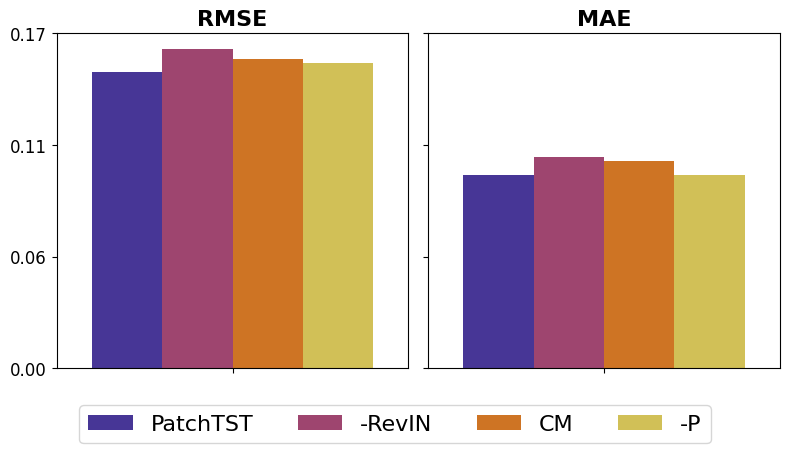

In [65]:
to_group = ['Country', 'Pred_len']
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_barplots(grouped_means, 'Model', col_name='Metrics', palette='CMRmap')

In [66]:
styled_df.to_html(os.path.join(path, 'timellm_512_10_power_2.html'), index=True)

In [67]:
all_df = pd.concat([timellm_df, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [68]:
all_df = pd.concat([timellm_df_336, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [69]:
all_df = pd.concat([timellm_df_336, timellm_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

# 6. Decomposition

In [70]:
decomposition_df = read_results_csv('patchtst/patchtst_decomposition.csv', 
                                    columns_to_extract=('Decomposition', ['RMSE', 'MAE'])
                                    )

#all_df = pd.concat([patchtst_df, decomposition_df], axis=1)

# Change country codes to country names
decomposition_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in decomposition_df.index],
    names=level_names
)

# Scale
decomposition_df_scale = decomposition_df * scale
all_df = pd.concat([result_df, decomposition_df_scale], axis=1)

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df, decimal_places=2)
styled_df